# 1. **Analisis Espacial**

Empezamos generando unos datos artificiales.

In [1]:
import numpy as np
s = np.array([[5,20],[20,2],[25,32],[8,39],[10,17],[35,20],[38,10]]) # Coordenadas
z = np.array([[100,70,60,90,50,80,40]]).T # magnitudes de cada coordenada
s_star = np.array([20,20]) # Coordenada a evaluar o estimar su magnitud

In [2]:
np.mean(z)

70.0

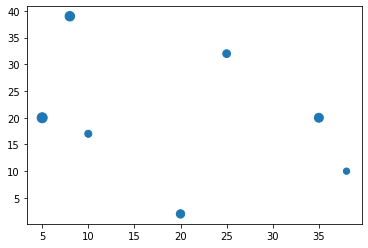

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(s[:,0],s[:,1],z)

## Usando interpolacion de scipy

La documentacion de la funcion RBF esta disponible [aqui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html). Empezamos importando la función Rbf

In [4]:
from scipy.interpolate import Rbf

Definimos la variable "rbfi" de la clase Rbf, con los datos de entrenamiento y con función Gaussiana. Calculamos los $z_*$ (test) empleando las coordenadas espaciales para el test.

In [5]:
rbfi = Rbf(s[:,0],s[:,1], z, function = 'gaussian')
z_est = rbfi(s_star[0], s_star[1])
print(z_est)

32.156746499284544


Generamos un *grid* de puntos espaciales para graficar el contorno estimado a partir de la funcion "rbfi". 

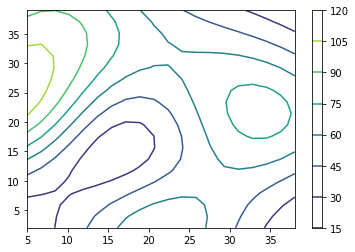

In [6]:
s0 = np.linspace(np.min(s[:,0]), np.max(s[:,0]), 20)
s1 = np.linspace(np.min(s[:,1]), np.max(s[:,1]), 20)
ss0, ss1 = np.meshgrid(s0, s1)

z_grid = rbfi(ss0, ss1)

plt.contour(ss0, ss1, z_grid)
plt.colorbar()

Ahora utilizamos la función cubica ('cubic') de la clase Rbf.

In [7]:
rbfi = Rbf(s[:,0],s[:,1], z, function = 'cubic')
z_est = rbfi(s_star[0], s_star[1])
print(z_est)

52.21147090365459


Generamos el *grid* para evaluar la nueva función basada en la opción cubica.

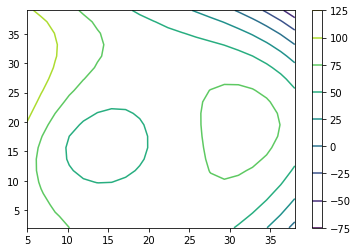

In [8]:
s0 = np.linspace(np.min(s[:,0]), np.max(s[:,0]), 20)
s1 = np.linspace(np.min(s[:,1]), np.max(s[:,1]), 20)
ss0, ss1 = np.meshgrid(s0, s1)

z_grid = rbfi(ss0, ss1)

plt.contour(ss0, ss1, z_grid)
plt.colorbar()

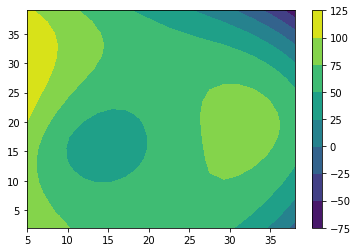

In [9]:
cp = plt.contourf(ss0, ss1, z_grid)
plt.colorbar(cp)

## Usando procesos Gaussianos 

In [10]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

In [11]:
reg = GPR(kernel = RBF()) # Se emplea el kernel RBF o exponencial cuadratico
reg.fit(X = s, y = z) #Se realiza la estimacion de los hiperparametros
ss_gp = np.vstack((ss0.flatten(), ss1.flatten())).T # Se agrupan los datos para la prediccion
predicted = reg.predict(ss_gp) #Se realiza la prediccion

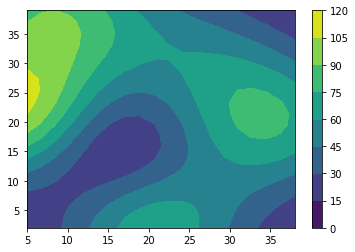

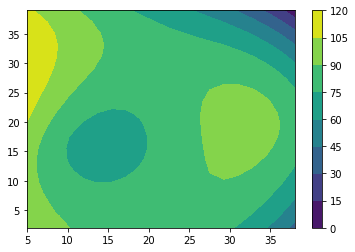

In [12]:
plt.figure()
cp = plt.contourf(ss0, ss1, predicted.reshape((20,20)))
plt.colorbar(cp)

plt.figure()
plt.contourf(ss0, ss1, z_grid)
plt.colorbar(cp)

# 2. **Análisis Espacio-Temporal**

Empezamos generando una base de datos espacio-temporal

In [13]:
import numpy as np
import torch

In [14]:
t = np.linspace(0,1,50)
z1 = np.sin(2*np.pi*t)
z2 = np.cos(2*np.pi*t)
z3 = z1 + z2
S = np.array([[1,0],[0,1],[0.5,1]])
U = torch.from_numpy(np.hstack((np.repeat(S, [50,50,50], axis = 0), np.hstack((t,t,t))[:, np.newaxis])))
z = torch.from_numpy(np.hstack((z1,z2,z3)) )

In [15]:
U.shape, z.shape

(torch.Size([150, 3]), torch.Size([150]))

https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html

In [16]:
!pip install GPyTorch

     |████████████████████████████████| 503 kB 5.1 MB/s 


Se dispone de diferentes metodos para construir los [kernels](https://docs.gpytorch.ai/en/v1.1.1/kernels.html)

In [17]:
import gpytorch
from gpytorch.kernels import ProductKernel, RBFKernel

Para ese caso construimos una funcion de covarianza para la entrada espacial, y una para la parte temporal. Finalmente obtenemos el producto de ambas:
$$ \text{cov}([\mathbf{s},t],[\mathbf{s}',t']) = \operatorname{RBF}(\mathbf{s},\mathbf{s}')\times \operatorname{RBF}(t,t')
$$
Debido que la matriz de indexación $\mathbf{X}$ tiene por filas $\mathbf{x}_i=[\mathbf{s}_i,t_i]$, entonces la covarianza de la parte espacial opera sobre las dos primeras dimensiones, mientras que la covarianza temporal opera sobre la ultima dimensión.

In [18]:
# We will use the simplest form of GP model, exact inference
class GPR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ProductKernel(RBFKernel(active_dims=(0,1)),RBFKernel(active_dims=(2)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPR(U, z, likelihood)

La función de covarianza tambien se puede construir explicitamente empleando el operador del producto, *, en Python. 

In [19]:
cov1 = gpytorch.kernels.RBFKernel(active_dims=(0,1))
cov2 = gpytorch.kernels.RBFKernel(active_dims=(2,))
x = torch.rand(10,3)
cov = cov1 * cov2 
res1 = cov(x).evaluate()

Con el siguiente codigo se realiza el entrenamiento de los parámetros de las funciones de covarianza y de la verosimilitud (ruido) 

In [20]:
# Iteraciones para el entrenamiento
training_iter = 50


# Activa el modo entrenamiento del modelo y la verosimilitud
model.train()
likelihood.train()

# Se emplea la optimizacion por Adam
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Se incluyen los parametros de una verosimilitud Gaussiana
], lr=0.05) #Tasa de aprendizaje (lr)

# "Loss" o perdida para GPs - el logaritmo de la verosimlitud marginal
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  # Output from model
  output = model(U)
  loss = -mll(output, z)
  loss.backward(torch.ones_like(loss))
  #print("Iter %d/%d" % (
  #    i + 1, training_iter ))
  optimizer.step()

Generamos un conjunto de datos de entrada de prueba para estimar los valores de $z$.

In [21]:
t_star = np.linspace(0,1,10)
#np.array([[1,0],[0,1],[0.5,1]])
S_star = torch.from_numpy(np.array([[0.9,0.1],[0.2,1.1],[0.4,0.8]]))
U_star = torch.from_numpy(np.hstack((np.repeat(S_star, [10,10,10], axis = 0), np.hstack((t_star,t_star,t_star))[:, np.newaxis])))
print(U_star.shape)

torch.Size([30, 3])


Ponemos el modelo y la verosimilitud en modo evaluación y hacemos la predicción del conjunto de datos creado en la celda anterior. 

In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    f_preds = model(U_star)
    y_preds = likelihood(model(U_star))

    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_covar = f_preds.covariance_matrix

Graficos la evolucion en el tiempo del punto [6,15] (primero 10 datos de la predicción), el cual esta muy cercano a al punto que tiene asociado la funcion seno.

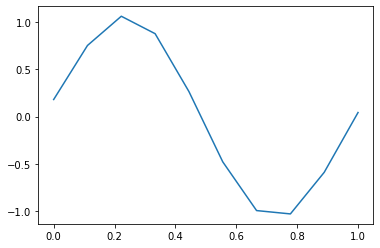

In [23]:
plt.plot(t_star,f_mean[:10])

EL conjunto de datos de 10:20 asociados a la coordenada espacial [19,2.5] esta mas cerca de la coordenada asociada al coseno.

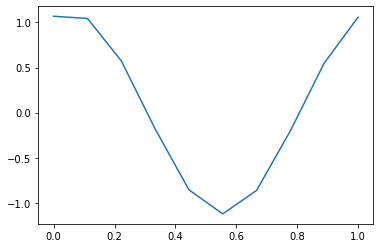

In [24]:
plt.plot(t_star, f_mean[10:20])

Finalmente, los ultimos 10 datos asociados a la coordenada [26,30], la cual esta cerca a la suma del seno y el coseno.

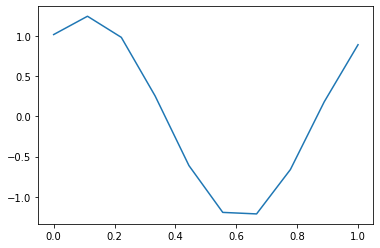

In [25]:
plt.plot(t_star,f_mean[20:])

In [26]:
S0 = np.linspace(np.min(S[:,0]), np.max(S[:,0]), 20)
S1 = np.linspace(np.min(S[:,1]), np.max(S[:,1]), 20)
ss_0, ss_1 = np.meshgrid(S0, S1)

ss_star = np.vstack((ss_0.flatten(), ss_1.flatten())).T

U_star = torch.from_numpy(np.hstack((ss_star, 0.5*np.ones((ss_gp.shape[0],1)) )) )


In [27]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    f_preds = model(U_star)
    y_preds = likelihood(model(U_star))

    f_mean = f_preds.mean
    f_var = f_preds.variance
    f_covar = f_preds.covariance_matrix

In [28]:
f_mean.shape

torch.Size([400])

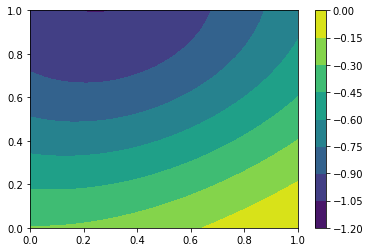

In [29]:
#np.array([[1,0],[0,1],[0.5,1]])
plt.figure()
cp = plt.contourf(ss_0, ss_1, f_mean.reshape((20,20)))
plt.colorbar(cp)

In [30]:
tast = np.linspace(0,1,100)

for k in range(100):
  U_star = torch.from_numpy(np.hstack((ss_star, tast[k]*np.ones((ss_gp.shape[0],1)) )) )

  # Get into evaluation (predictive posterior) mode
  model.eval()
  likelihood.eval()

  # Make predictions by feeding model through likelihood
  with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
      f_preds = model(U_star)
      y_preds = likelihood(model(U_star))

      f_mean = f_preds.mean
      f_var = f_preds.variance
      f_covar = f_preds.covariance_matrix

  plt.figure()
  cp = plt.contourf(ss_0, ss_1, f_mean.reshape((20,20)))
  plt.xlabel('t='+str(tast[k])+' s')
  plt.colorbar(cp)

  plt.savefig(str(k)+'.png')
  plt.close()


In [31]:
import imageio

In [32]:
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for k in range(100):
        image = imageio.imread(str(k)+'.png')
        writer.append_data(image)

In [33]:
import os
for k in range(100):
    os.remove(str(k)+'.png')

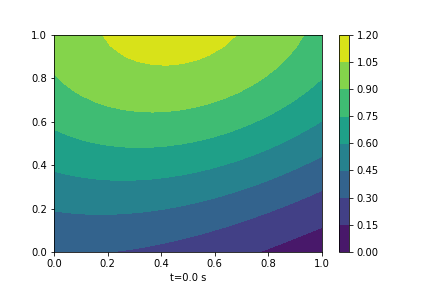

In [34]:
from IPython.display import Image
Image(open('/content/mygif.gif','rb').read())